In [1]:
from __future__ import print_function, division, absolute_import
import numpy as np
from scipy.optimize import fmin_l_bfgs_b, least_squares, fmin_slsqp, minimize
import pyfde
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import constrNMPy as cNM
from joblib import Parallel, delayed

sns.set()


def otto_model_create_data(x):
    """
    Run the otto model to generate numerical data
    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    f: frequencies of the data points

    example:
    zr, zj = otto_model_create_test_data(x)
    zr: 1D Numpy array of length f real component of z
    zj: 1D Numpy array of length f imaginary component of z
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    return np.real(ztot), np.abs(np.imag(ztot))


def otto_model_L1_log(x):
    """
    return the L1 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    L1 = (np.sum(np.abs(ir-er))/n) + (np.sum(np.abs(ij-ej))/n)
    return L1


def otto_model_L2_log(x):
    """
    return the L2 norm of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    ir = np.log10(zr)
    ij = np.log10(zj)
    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    er = np.log10(np.real(ztot))
    ej = np.log10(np.abs(np.imag(ztot)))
    e = np.concatenate((ir - er, ij - ej))
    L2 = np.dot(e.T, e)/n
    return np.sqrt(L2)


def otto_model_L_inf(x):
    """
    return the L infity norm of the otto model for x from some test data
    this returns the maximum deviation in the real + max deviation imaginary

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    L_inf = (np.max(np.abs(zr-np.real(ztot)))) +\
            (np.max(np.abs(zj-np.abs(np.imag(ztot)))))
    return L_inf


def otto_model_L2_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))
    e = (((zr-np.real(ztot))**2)/(np.abs(zmag))) + \
        (((zj-np.abs(np.imag(ztot)))**2)/(np.abs(zmag)))
    L2 = np.dot(e.T, e)
    return L2


def otto_model_L1_Kait(x):
    """
    return the L2 norm with Kaitlynn's nomalized deviation
    of the otto model for x from some test data

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """

    # glial encapsulation
    am = x[4]     # membrane area (cm**2)
    cm = 1e-6*am  # cell membrane capaacitance (uf/cm**2)
    rm = 3.33/am  # Cell membrane resistivity (ohm*cm**2)

    # 1j in Python is sqrt(-1.0)
    ecpe = 1.0 / (((1j*2*np.pi*f)**x[0])*(x[1]/1e6))
    ren = (x[2]*1e3) * np.ones(n)
    rex = (x[3]*1e3) * np.ones(n)

    # 2 parallel RC circuits in series
    cell_membrane = (1.0/((1j*2*np.pi*f*cm)+(1.0/rm))) + \
                    (1.0/((1j*2*np.pi*f*cm)+(1.0/rm)))
    zmag = np.sqrt((zr**2) + (zj**2))

    # combine total impedances
    ztot = ecpe + ren + (1.0 / ((1.0/(cell_membrane))+(1.0/rex)))

    e = (np.sum((np.abs((zr-np.real(ztot)))))/(n*np.abs(zmag))) + \
        (np.sum((np.abs((zj-np.abs(np.imag(ztot))))))/(n*np.abs(zmag)))
    L1 = np.dot(e.T, e)
    return L1


def plot_results(f, x_l1, x_l2, x_linf, x_k, title):
    """
    plots the results of all of the optimizations

    Input:
    x: 1D Numpy array or list with 5 elements as defined below
    x[0] = alpha CPE phase factor
    x[1] = K CPE magnitude factor
    x[2] = ren encapsulation resistance
    x[3] = rex extracellular resistance
    x[4] = am membrane area in cm**2
    """
    # plot the fitted data
    zr_l1, zj_l1 = otto_model_create_data(x_l1)
    zr_l2, zj_l2 = otto_model_create_data(x_l2)
    zr_linf, zj_linf = otto_model_create_data(x_linf)
    zr_lk, zj_lk = otto_model_create_data(x_k)

    plt.figure()
    plt.title(title)
    plt.plot(zr, zj, '.-', label='Test Data')
    plt.plot(zr_l1, zj_l1, 'o', label='Log10 L1 norm')
    plt.plot(zr_l2, zj_l2, 's', label='Log10 L2 norm')
    plt.plot(zr_linf, zj_linf, '>', label=r"L1 Kaitlynn's norm")
    plt.plot(zr_lk, zj_lk, '<', label="Kaitlynn's norm")

    plt.xlabel(r'$Z_r (\Omega)$')
    plt.ylabel(r'$Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'rj.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zj, '.-', label='Test Data')
    plt.plot(f, zj_l1, 'o', label='Log10 L1 norm')
    plt.plot(f, zj_l2, 's', label='Log10 L2 norm')
    plt.plot(f, zj_linf, '>', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zj_lk, '<', label="Kaitlynn's norm")
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_j (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig('figs/' + title + 'j.png', dpi=300, bbox_inches='tight')

    plt.figure()
    plt.title(title)
    plt.plot(f, zr, '.-', label='Test Data')
    plt.plot(f, zr_l1, 'o', label='Log10 L1 norm')
    plt.plot(f, zr_l2, 's', label='Log10 L2 norm')
    plt.plot(f, zr_linf, '>', label=r"L1 Kaitlynn's norm")
    plt.plot(f, zr_lk, '<', label="Kaitlynn's norm")
    plt.xlabel(r'$f$')
    plt.ylabel(r'$Z_r (\Omega)$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()
    plt.savefig('figs/' + title + 'r.png', dpi=300, bbox_inches='tight')

    # real residuals
    # er = zr - zr_x
    # imaginary residuals
    # ej = zj - zj_x

    # plt.figure()
    # plt.title(title)
    # plt.semilogx(f, er, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Real residuals')
    # plt.grid()

    # plt.figure()
    # ptl.title(title)
    # plt.semilogx(f, ej, 'o')
    # plt.xlabel('$f$')
    # plt.ylabel('Imaginary residuals')
    # plt.grid()
    # plt.show()


def my_opt_fun(obj_function):
    # run differential evolution
    # solver = pyfde.ClassicDE(obj_function, n_dim=5, n_pop=50,
    #                          limits=bounds, minimize=True)
    solver = pyfde.JADE(obj_function, n_dim=5, n_pop=50,
                        limits=bounds, minimize=True)
    solver.c = np.random.random()
    solver.p = np.random.random()
    solver.cr = np.random.random()
    solver.f = np.random.random()
    # solver.cr, solver.f = 1.0, 0.9
    best, fit = solver.run(n_it=1000)
    fit = fit*-1
    # polish with constrained nelder mead simplex optimization
    res_cnm = cNM.constrNM(obj_function, best, bounds[:, 0], bounds[:, 1],
                           full_output=True, xtol=1e-15, ftol=1e-15)
    # if polish better save polish results
    if res_cnm['fopt'] < fit:
        opts = res_cnm['fopt']
        results_x = res_cnm['xopt']
        # print('Polish was better')
    else:
        opts = fit
        results_x = best
        # print('Polish did not help')

    # res_bfgs = fmin_l_bfgs_b(obj_function, best, fprime=None, args=(),
    #                          approx_grad=True, bounds=bounds, m=10,
    #                          factr=10000000.0, pgtol=1e-05, epsilon=1e-05,
    #                          iprint=-1, maxfun=100000, maxiter=15000,
    #                          disp=None, callback=None, maxls=100)
    # if polish better save polish results
    # print(fit, res_bfgs[1])
    # if res_bfgs[1] < fit:
    #     opts = res_bfgs[1]
    #     results_x = res_bfgs[0]
    #     print('Polish was better')
    # else:
    #     opts = fit
    #     results_x = best
    #     print('Polish did not help')

    # res_slsqp = fmin_slsqp(obj_function, best, bounds=bounds, iter=1e10,
    #                        acc=1e-15, iprint=0, disp=None, full_output=1,
    #                        epsilon=1.4901161193847656e-08, callback=None)
    # # if polish better save polish results
    # # print(fit, res_slsqp[1])
    # if res_slsqp[1] < fit:
    #     opts = res_slsqp[1]
    #     results_x = res_slsqp[0]
    #     print('Polish was better')
    # else:
    #     opts = fit
    #     results_x = best

    # res_ls = least_squares(otto_model_L2_Kait_vec, best, bounds=bounds.T, method='trf', ftol=1e-15, xtol=1e-15, gtol=1e-15, loss='linear')
    # # print(res_ls)
    # # if polish better save polish results
    # # print(fit, res_slsqp[1])
    # if 2.0*res_ls.cost < fit:
    #     opts = res_ls.cost*2.0
    #     results_x = res_ls.x
    #     print('Polish was better')
    # else:
    #     opts = fit
    #     results_x = best
    
    # res_tr = minimize(obj_function, best, method='trust-constr', bounds=bounds, tol=None, callback=None, options={'grad': None, 'xtol': 1e-15, 'gtol': 1e-15, 'barrier_tol': 1e-08, 'sparse_jacobian': None, 'maxiter': 1e10, 'verbose': 0, 'finite_diff_rel_step': None, 'initial_constr_penalty': 1.0, 'initial_tr_radius': 1.0, 'initial_barrier_parameter': 0.1, 'initial_barrier_tolerance': 0.1, 'factorization_method': None, 'disp': False})
    # # print(res_ls)
    # # if polish better save polish results
    # # print(fit, res_slsqp[1])
    # if res_tr.cost < fit:
    #     opts = res_tr.cost
    #     results_x = res_tr.x
    #     print('Polish was better')
    # else:
    #     opts = fit
    #     results_x = best
    return np.append(results_x, opts)


def opt_routine(obj_function, runs=50, n_proc=4):
    """
    An optimization routine which first runs a Differential Evolution
    (global optimization), then runs a Bounded BFGS (gradient optimization)
    to polish the result. This processes is repeated for a user defined number
    of runs (which default to 10).

    Input:
    obj_function - Your objective function to minimize
    runs (int: optional) - the number  of times to repeat the optimization
                            process (defaults runs=10)

    Output: results_x, opts, best_x, best_opt
    results_x - a 2D array of all x values from all optimization runs
    opts - a 1D array of the objective values from all optimization runs
    best_x - a 1D array of the best x values found
    best_opt - the best objective value
    """

    # initialize result arrays
    results_x = np.zeros((runs, 5))
    opts = np.zeros(runs)
    t0 = time()
    opt_res = Parallel(n_jobs=n_proc)(delayed(my_opt_fun)(obj_function) for _ in range(runs))  # noqa
    opt_res = np.array(opt_res)
    results_x = opt_res[:, :5]
    opts = opt_res[:, 5]
    t1 = time()
    print('Optimization runtime %0.4f seconds' % (t1-t0))
    # find the best result
    best_index = np.nanargmin(opts)
    best_opt = opts[best_index]
    best_x = results_x[best_index]
    print('Set of optima:', opts)
    print('Best Objective value:', best_opt)
    print('Paramters:', best_x, '\n')
    print('\n')
    return results_x, opts, best_x, best_opt


Optimization runtime 60.5470 seconds
Set of optima: [0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833403 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833403 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404 0.01833404
 0.01833404 0.01833404]
Best Objective value: 0.0183340308548249
Paramters: [3.96615696e-01 6.32998356e-01 1.71533368e+00 1.00000000e-04
 1.01668693e-10] 



Optimization runtime 53.7790 seconds
Set of optima: [0.02725514 0.02725514 0.02725514 0.02725514 0.02725514 0.02725514
 0.02725514 0.02725514 0.02725514 0.02725514 0.02725514 0.02725514
 0.02725514 0.02725514 0.02725513 0.02725514 0.02725514 0.02725514
 

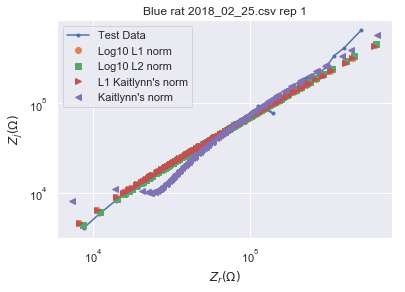

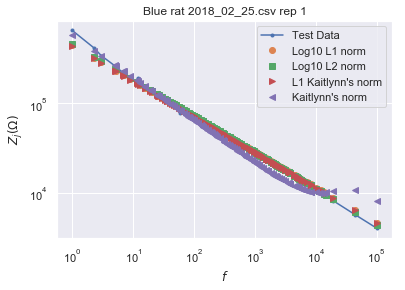

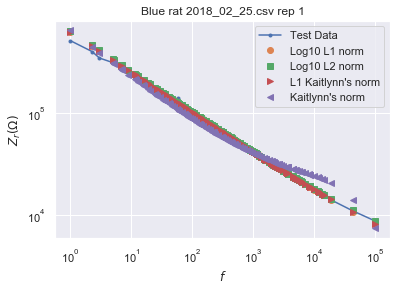

Optimization runtime 57.1232 seconds
Set of optima: [0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009 0.01678009
 0.01678009 0.01678009]
Best Objective value: 0.016780085124392264
Paramters: [3.92039529e-01 6.38104269e-01 2.01609895e+00 1.00000000e-04
 1.06877812e-10] 



Optimization runtime 55.5156 seconds
Set of optima: [0.02951914 0.02951914 0.02951914 0.02951914 0.02951914 0.02951914
 0.02951914 0.02951914 0.02951914        nan 0.02951914 0.02951914
 0.02951914 0.02951914 0.02951914 0.02951914 0.02951914 0.02951914

<Figure size 432x288 with 0 Axes>

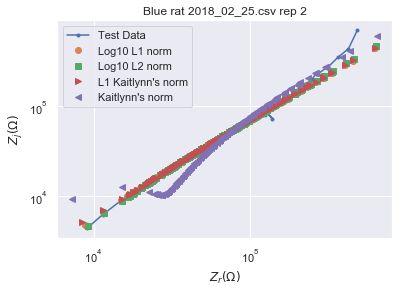

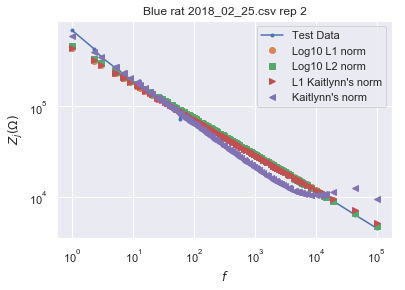

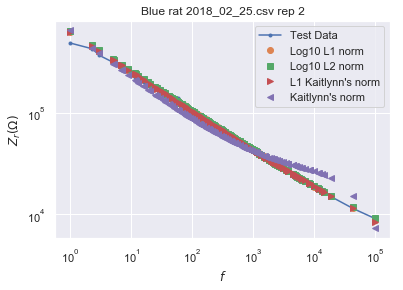

Optimization runtime 75.6227 seconds
Set of optima: [0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536]
Best Objective value: 0.06997536017626077
Paramters: [4.33003264e-01 5.51412906e-01 1.31134514e+01 7.77939677e+29
 1.28123651e-03] 



Optimization runtime 70.2657 seconds
Set of optima: [0.11365234 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234
 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234
 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234


<Figure size 432x288 with 0 Axes>

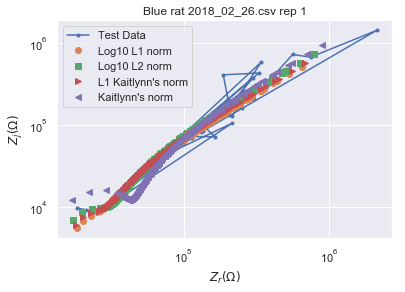

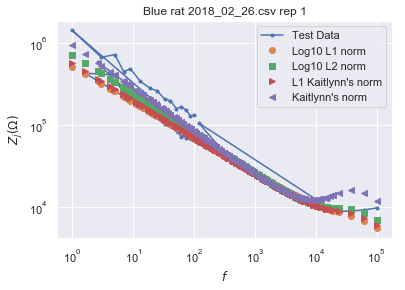

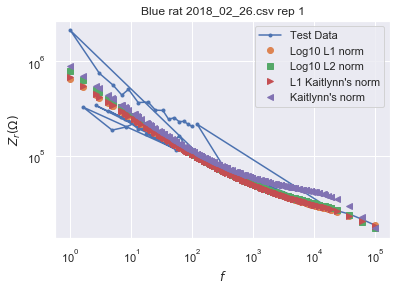

Optimization runtime 85.5301 seconds
Set of optima: [0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997537 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536 0.06997536
 0.06997536 0.06997536]
Best Objective value: 0.06997536017626077
Paramters: [4.33003264e-01 5.51412906e-01 1.31134514e+01 1.00000000e+30
 1.28123651e-03] 



Optimization runtime 87.3257 seconds
Set of optima: [0.11365234 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234
 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234
 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234 0.11365234


<Figure size 432x288 with 0 Axes>

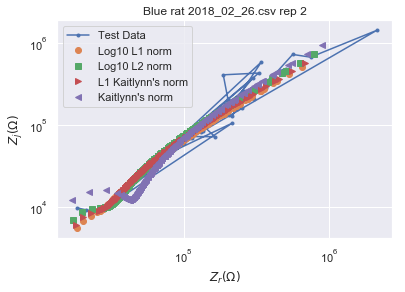

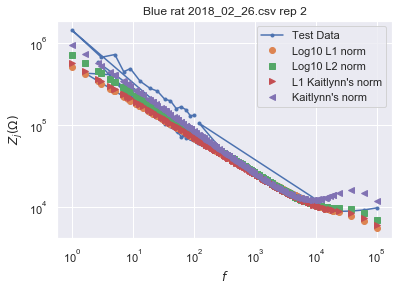

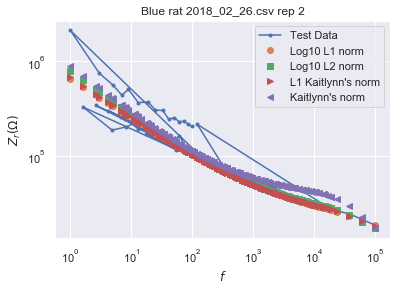

Optimization runtime 81.0620 seconds


ValueError: All-NaN slice encountered

<Figure size 432x288 with 0 Axes>

In [2]:
# optimization bounds
bounds = np.ones((5, 2))*1e-4
bounds[:, 1] = 1000.0
bounds[3, 1] = 1e30
bounds[2, 0] = 1e-2
bounds[4, 0] = 1e-10
bounds[0, 1] = 10.0

# my data set
data_prefix = 'data/'
data_list = ['2018_02_25.csv', '2018_02_26.csv', '2018_02_27.csv',
             '2018_03_03.csv', '2018_03_10.csv']

res_l1 = np.zeros((10, 6))
res_l2 = np.zeros((10, 6))
res_lk1 = np.zeros((10, 6))
res_lk2 = np.zeros((10, 6))

for ind, data in enumerate(data_list):
    dataset = pd.read_csv(data_prefix+data)
    for i in range(2):
        j = i*3
        f = dataset.values[:, j]
        n = len(f)
        zr = dataset.values[:, j+1]
        zj = dataset.values[:, j+2]
        # Run the optimiziation
        # # generate fake results
        # zr, zj = otto_model_create_data([0.68, 8.8, 34.0, 45.0, 89.0])
        # peform the optimizations
        _, _, x_l1, opt_l1 = opt_routine(otto_model_L1_log)
        _, _, x_l2, opt_l2 = opt_routine(otto_model_L2_log)
        _, _, x_lk1, opt_lk1 = opt_routine(otto_model_L1_Kait)
        _, _, x_lk2, opt_lk2 = opt_routine(otto_model_L2_Kait)
        plot_results(f, x_l1, x_l2, x_lk1, x_lk2,
                     'Blue rat ' + data + ' rep ' + str(i+1))
        # # save the results into the array
        res_l1[ind*2 + i, :5] = x_l1
        res_l1[ind*2 + i, 5] = opt_l1
        res_l2[ind*2 + i, :5] = x_l2
        res_l2[ind*2 + i, 5] = opt_l2
        res_lk1[ind*2 + i, :5] = x_lk1
        res_lk1[ind*2 + i, 5] = opt_lk1
        res_lk2[ind*2 + i, :5] = x_lk2
        res_lk2[ind*2 + i, 5] = opt_lk2

%store res_l1
%store res_l2
%store res_lk1
%store res_lk2